In [9]:
# import the required libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import string

import warnings
warnings.filterwarnings("ignore")

In [2]:
# read the dataset
df = pd.read_csv('yelp.csv')

In [3]:
#check the head
df.head()

,business_id,date,review_id,stars,text,type,user_id,cool,useful,funny
0,9yKzy9PApeiPPOUJEtnvkg,2011-01-26,fWKvX83p0-ka4JS3dc6E5A,5,My wife took me here on my birthday for breakf...,review,rLtl8ZkDX5vH5nAx9C3q5Q,2,5,0
1,ZRJwVLyzEJq1VAihDhYiow,2011-07-27,IjZ33sJrzXqU-0X6U8NwyA,5,I have no idea why some people give bad review...,review,0a2KyEL0d3Yb1V6aivbIuQ,0,0,0
2,6oRAC4uyJCsJl1X0WZpVSA,2012-06-14,IESLBzqUCLdSzSqm0eCSxQ,4,love the gyro plate. Rice is so good and I als...,review,0hT2KtfLiobPvh6cDC8JQg,0,1,0
3,_1QQZuf4zZOyFCvXc0o6Vg,2010-05-27,G-WvGaISbqqaMHlNnByodA,5,"Rosie, Dakota, and I LOVE Chaparral Dog Park!!...",review,uZetl9T0NcROGOyFfughhg,1,2,0
4,6ozycU1RpktNG2-1BroVtw,2012-01-05,1uJFq2r5QfJG_6ExMRCaGw,5,General Manager Scott Petello is a good egg!!!...,review,vYmM4KTsC8ZfQBg-j5MWkw,0,0,0


In [4]:
# get info of the dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   business_id  10000 non-null  object
 1   date         10000 non-null  object
 2   review_id    10000 non-null  object
 3   stars        10000 non-null  int64 
 4   text         10000 non-null  object
 5   type         10000 non-null  object
 6   user_id      10000 non-null  object
 7   cool         10000 non-null  int64 
 8   useful       10000 non-null  int64 
 9   funny        10000 non-null  int64 
dtypes: int64(4), object(6)
memory usage: 781.4+ KB


The dataset is already cleaned from the null value.

From this dataset, our focus is only in the 'stars' and 'text' (review), so lets make a new dataframe.

In [10]:
# make a new dataframe that only contains 'stars' and 'text'
# also check the head
reviews = df[['stars','text']]
reviews.rename(columns={'text':'review'},inplace=True)
reviews.head()

,stars,review
0,5,My wife took me here on my birthday for breakf...
1,5,I have no idea why some people give bad review...
2,4,love the gyro plate. Rice is so good and I als...
3,5,"Rosie, Dakota, and I LOVE Chaparral Dog Park!!..."
4,5,General Manager Scott Petello is a good egg!!!...


In [11]:
# create a new feature that count the character of the review
reviews['length'] = reviews['review'].apply(len)
reviews.head()

,stars,review,length
0,5,My wife took me here on my birthday for breakf...,889
1,5,I have no idea why some people give bad review...,1345
2,4,love the gyro plate. Rice is so good and I als...,76
3,5,"Rosie, Dakota, and I LOVE Chaparral Dog Park!!...",419
4,5,General Manager Scott Petello is a good egg!!!...,469


Okay, I'd like to do some EDA first, maybe there are a correlation between the star and the character length of the reviews.

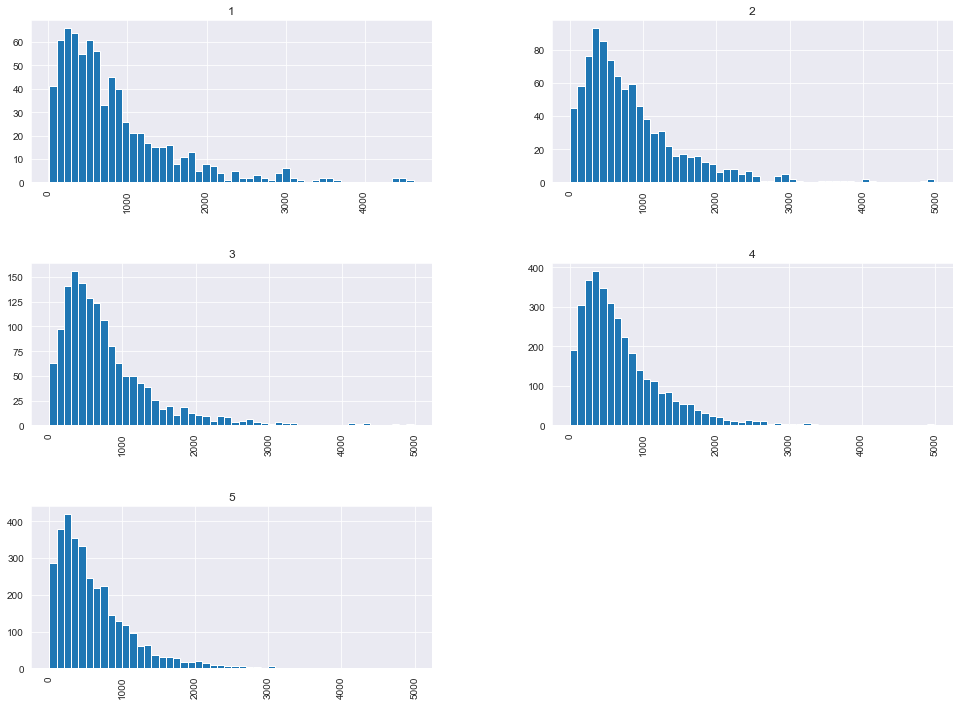

In [39]:
# create a hist plot on the 'length' and separate by 'stars'
sns.set_style('darkgrid')
reviews.hist(column='length',by='stars',figsize=(16,12),bins=50)
plt.show()

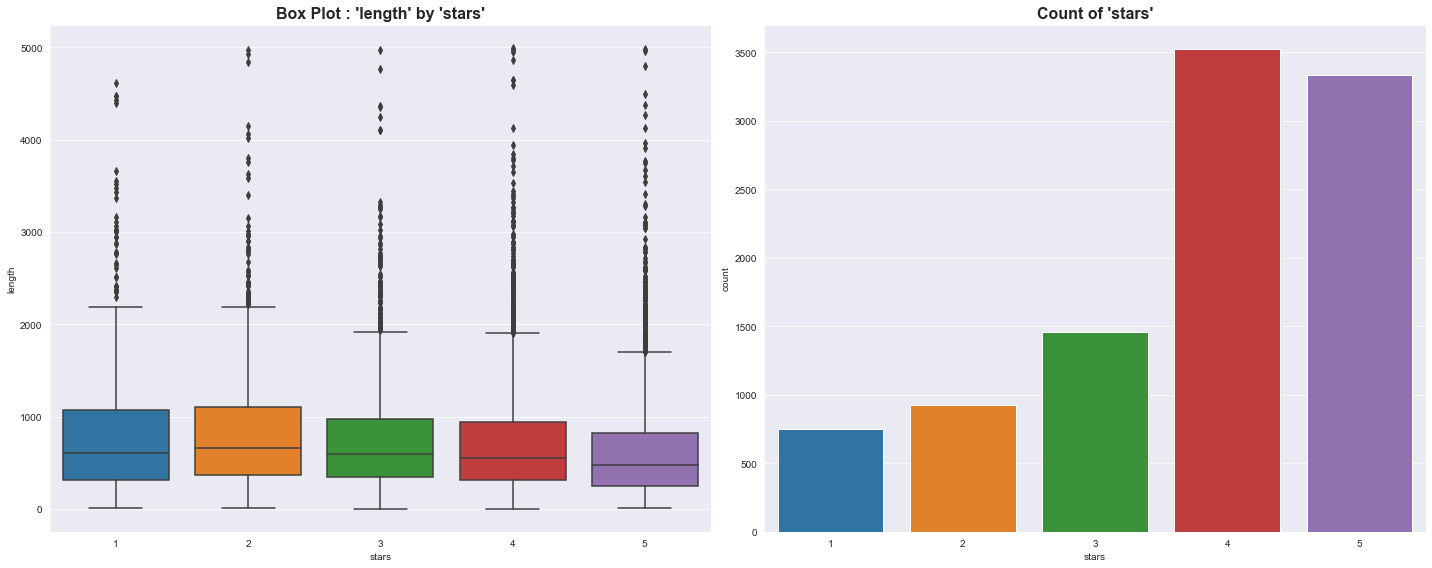

In [45]:
# create a box plot to see the min, max, and average of the character length for each 'stars'
# check the count of the 'stars'
fig1, ax = plt.subplots(1,2,figsize=(20,8))
sns.boxplot('stars','length',data=reviews,ax=fig1.axes[0])
fig1.axes[0].set_title("Box Plot : 'length' by 'stars'",fontsize=16,fontweight='bold')
sns.countplot(reviews['stars'],ax=fig1.axes[1])
fig1.axes[1].set_title("Count of 'stars'",fontsize=16,fontweight='bold')
plt.tight_layout()
plt.show()

As we can see, It has tendency that when the stars rating increase, the character length will decrease. What caused this to happen? I guest that a person who give a low stars would most likely to give a long complain to express their dissatisfaction, while the opposite usually only give a small word like 'good service' or 'nice product'.

### Time to build our NLP and Classification Model!

The first thing, we should create analyzer for text processing.

In [46]:
# import stopwords from nltk library to eleminate the stop words (e.g : 'the','of','in')
from nltk.corpus import stopwords

In [96]:
# create the text analyzer
def text_process(rev):
    nopunc = [char for char in rev if char not in string.punctuation]
    nopunc = ''.join(nopunc)
    return [word for word in nopunc.split() if word.lower not in stopwords.words('english')]

Next, I will build a pipeline that would do some calculation step which are :
- Vectorizer
- Create the Tfidf
- Classifier

For the classifier, I'd like to use MultinomialNB

In [49]:
# import the required libraries
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

In [97]:
# build the pipeline
pipeline = Pipeline([
    ('bow',CountVectorizer(analyzer=text_process)),
    ('tfidf',TfidfTransformer()),
    ('classifier',MultinomialNB())
])

Before we train our model, lets split our dataset into traning and test dataset

In [51]:
# import train_test_split from sklearn
from sklearn.model_selection import train_test_split

In [102]:
# seperate the feature and the target
X = reviews.drop(['stars','length'],axis=1).squeeze()
y = reviews['stars']

In [103]:
# create the split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [104]:
# build the model
pipeline.fit(X_train,y_train)

Pipeline(steps=[('bow',
                 CountVectorizer(analyzer=<function text_process at 0x000001D6DB1EC160>)),
                ('tfidf', TfidfTransformer()),
                ('classifier', MultinomialNB())])

In [105]:
# make prediction
pred = pipeline.predict(X_test)

In [108]:
# import classification report
from sklearn.metrics import classification_report,confusion_matrix

In [109]:
# evaluate the model
print(confusion_matrix(y_test,pred))
print('\n')
print(classification_report(y_test,pred))

[[  0   0   0 202  17]
 [  0   0   0 271   7]
 [  0   0   0 426   8]
 [  0   0   0 996  58]
 [  0   0   0 771 244]]


              precision    recall  f1-score   support

           1       0.00      0.00      0.00       219
           2       0.00      0.00      0.00       278
           3       0.00      0.00      0.00       434
           4       0.37      0.94      0.54      1054
           5       0.73      0.24      0.36      1015

    accuracy                           0.41      3000
   macro avg       0.22      0.24      0.18      3000
weighted avg       0.38      0.41      0.31      3000



It seems that the result is quite bad. Maybe, we should not use TfidfTranformer. Lets try again!

In [111]:
# build the pipeline without Tfidf
pipeline2 = Pipeline([
    ('bow',CountVectorizer(analyzer=text_process)),
    ('classifier',MultinomialNB())
])

In [112]:
# train the new pipeline
pipeline2.fit(X_train,y_train)

Pipeline(steps=[('bow',
                 CountVectorizer(analyzer=<function text_process at 0x000001D6DB1EC160>)),
                ('classifier', MultinomialNB())])

In [113]:
# make prediction for the new model
pred2 = pipeline2.predict(X_test)

In [114]:
# evaluate the new model
print(confusion_matrix(y_test,pred2))
print('\n')
print(classification_report(y_test,pred2))

[[ 43  16   9 113  38]
 [  9  11  23 196  39]
 [  0   1  18 382  33]
 [  2   1   6 821 224]
 [  0   0   1 468 546]]


              precision    recall  f1-score   support

           1       0.80      0.20      0.32       219
           2       0.38      0.04      0.07       278
           3       0.32      0.04      0.07       434
           4       0.41      0.78      0.54      1054
           5       0.62      0.54      0.58      1015

    accuracy                           0.48      3000
   macro avg       0.51      0.32      0.32      3000
weighted avg       0.49      0.48      0.43      3000



**I think this one is much better**. Please feel free if you have any other idea to improve the model. You can use **GridSeacrhCV** to find best param_grid.

# Thank You!